In [1]:
# Import các thư viện cần thiết
import torch
import learn2learn as l2l
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# Load dữ liệu
data = pd.read_csv("../../../Dataset/FFIV_Stock.csv")

In [6]:
data

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,FFIV,166.529999,166.529999,168.330002,165.419998,167.600006,756400
1,3/4/2019,FFIV,163.289993,163.289993,167.289993,161.710007,166.970001,553700
2,3/5/2019,FFIV,162.149994,162.149994,163.399994,161.970001,163.240005,511300
3,3/6/2019,FFIV,161.080002,161.080002,162.139999,159.949997,161.919998,527000
4,3/7/2019,FFIV,158.990005,158.990005,161.250000,157.910004,160.630005,783200
...,...,...,...,...,...,...,...,...
1319,5/28/2024,FFIV,168.339996,168.339996,170.000000,167.339996,169.119995,497000
1320,5/29/2024,FFIV,168.229996,168.229996,170.509995,166.550003,167.080002,655200
1321,5/30/2024,FFIV,167.300003,167.300003,168.669998,166.130005,168.309998,401100
1322,5/31/2024,FFIV,168.970001,168.970001,169.130005,164.580002,166.479996,1137700


In [7]:
data.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,163.434992,163.434992,165.268542,161.482228,163.397160,6.147710e+05
std,29.329932,29.329932,29.577160,29.115418,29.336975,3.981027e+05
min,90.550003,90.550003,93.830002,79.779999,88.750000,1.205000e+05
25%,141.537506,141.537506,143.384998,139.952503,141.632496,3.971500e+05
50%,155.590004,155.590004,157.345001,154.154999,156.070000,5.293500e+05
75%,186.022503,186.022503,187.654995,184.379997,186.260002,6.974750e+05
max,247.779999,247.779999,249.000000,245.899994,247.779999,5.232700e+06


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [9]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [10]:
detect_outlier(data, 'Close')

Empty DataFrame
Columns: [Date, Symbol, Adj Close, Close, High, Low, Open, Volume]
Index: []


In [11]:
df=data.reset_index()['Close']

In [12]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       166.529999
1       163.289993
2       162.149994
3       161.080002
4       158.990005
           ...    
1319    168.339996
1320    168.229996
1321    167.300003
1322    168.970001
1323    166.910004
Name: Close, Length: 1324, dtype: float64

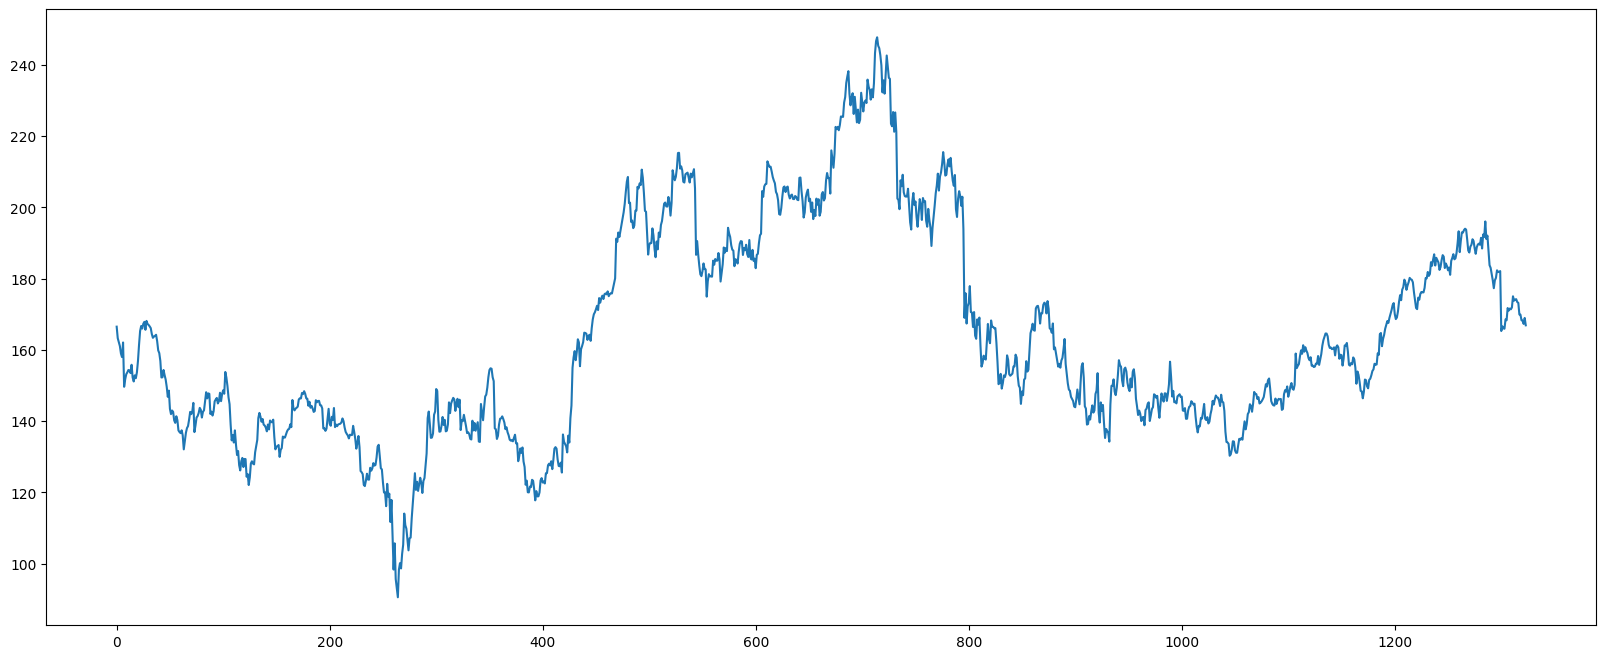

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.show()

In [14]:
# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [15]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.4832411 ],
       [0.46263431],
       [0.45538379],
       ...,
       [0.48813841],
       [0.49875978],
       [0.48565797]])

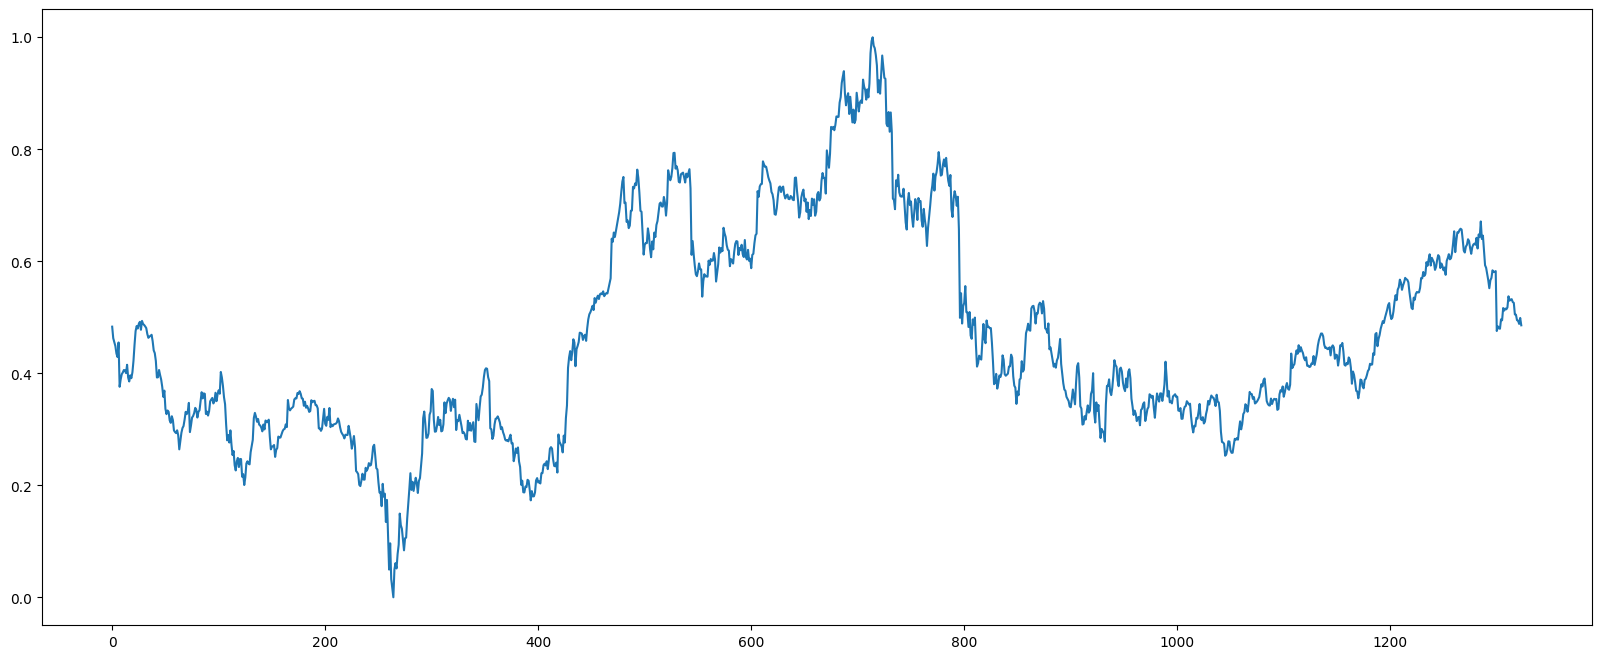

In [16]:
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.show()

In [17]:
# Chia train test
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [18]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [19]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [20]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
# Tạo DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(ytest))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
# Xây dựng mô hình
class StockPredictor(nn.Module):
    def __init__(self):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=24, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(24, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [23]:
# Định nghĩa hàm meta-learning
def fast_adapt(batch, learner, loss, adaptation_steps, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    for step in range(adaptation_steps):
        predictions = learner(data).view(-1)
        train_loss = loss(predictions, labels.view(-1))
        learner.adapt(train_loss)
    return train_loss

In [24]:
# Định nghĩa quá trình training
def meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps, meta_batch_size, device):
    for epoch in range(100):
        meta_loss = 0.0
        for batch in train_loader:
            learner = maml.clone()
            batch_loss = fast_adapt(batch, learner, loss, adaptation_steps, device)
            meta_loss += batch_loss.item()
            meta_optimizer.zero_grad()
            batch_loss.backward()
            # Ensure that only leaf tensors are used to calculate the gradients
            for param in maml.parameters():
                if param.grad is not None:
                    param.grad = param.grad.clone().detach()
            meta_optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {meta_loss/len(train_loader)}')

In [25]:
# Khởi tạo mô hình và các thành phần cần thiết
device = torch.device('cpu')
model = StockPredictor().to(device)
maml = l2l.algorithms.MAML(model, lr=0.01)
meta_optimizer = optim.Adam(maml.parameters(), lr=0.001)
loss = nn.MSELoss()

In [26]:
# Training mô hình
meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps=3, meta_batch_size=28, device=device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:810: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad


Epoch 1, Loss: 0.16856350463170272
Epoch 2, Loss: 0.06505783217457625
Epoch 3, Loss: 0.042535336258319706
Epoch 4, Loss: 0.03546251270633478
Epoch 5, Loss: 0.027046258059831765
Epoch 6, Loss: 0.014080082782759117
Epoch 7, Loss: 0.00627970931908259
Epoch 8, Loss: 0.004557093050187597
Epoch 9, Loss: 0.0041532558389008045
Epoch 10, Loss: 0.0038844006709181345
Epoch 11, Loss: 0.0034936760695507894
Epoch 12, Loss: 0.00333987779986973
Epoch 13, Loss: 0.0033173005347355055
Epoch 14, Loss: 0.003181587868871597
Epoch 15, Loss: 0.003073848336218641
Epoch 16, Loss: 0.0028523479839070486
Epoch 17, Loss: 0.0029665999150333498
Epoch 18, Loss: 0.0025615970102640297
Epoch 19, Loss: 0.0027964902558149053
Epoch 20, Loss: 0.0025460515529490435
Epoch 21, Loss: 0.0023837821701398264
Epoch 22, Loss: 0.002272082564349358
Epoch 23, Loss: 0.0024192806046742657
Epoch 24, Loss: 0.0022731891009383476
Epoch 25, Loss: 0.0023162478688531197
Epoch 26, Loss: 0.0022578871665665736
Epoch 27, Loss: 0.0022193029737816406


In [27]:
# Dự đoán và hiển thị kết quả trên tập test
model.eval()
predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        x = torch.Tensor(X_test[i:i+1]).to(device)
        pred = model(x).cpu().numpy()
        predictions.append(pred)

predictions = np.array(predictions).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [28]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((predictions - ytest) ** 2))
test_mape = calculate_mape(ytest, predictions)
test_mae = calculate_mae(ytest, predictions)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 24.737749964866296
Testing MAPE: 12.457653072247114
Testing MAE: 20.12915513103531


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 30):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_30.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 30 ngày tiếp theo:")
print(predicted_30_days)


Dự báo 30 ngày tiếp theo:
[[168.63490828]
 [168.69999899]
 [169.01622149]
 [169.48077827]
 [170.03887806]
 [170.66054567]
 [171.32924016]
 [172.03553366]
 [172.77391565]
 [173.54093736]
 [174.33448082]
 [175.15320586]
 [175.99636276]
 [176.86357666]
 [177.75472572]
 [178.66981932]
 [179.60888556]
 [180.57195258]
 [181.55892664]
 [182.56951723]
 [183.60325576]
 [184.65940188]
 [185.73691534]
 [186.83450284]
 [187.95049624]
 [189.08296499]
 [190.22962239]
 [191.38789125]
 [192.55491322]
 [193.72759566]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Dự báo 60 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_60 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 60):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 60 ngày tiếp theo:")
print(predicted_60_days)


Dự báo 60 ngày tiếp theo:
[[168.63490828]
 [168.69999899]
 [169.01622149]
 [169.48077827]
 [170.03887806]
 [170.66054567]
 [171.32924016]
 [172.03553366]
 [172.77391565]
 [173.54093736]
 [174.33448082]
 [175.15320586]
 [175.99636276]
 [176.86357666]
 [177.75472572]
 [178.66981932]
 [179.60888556]
 [180.57195258]
 [181.55892664]
 [182.56951723]
 [183.60325576]
 [184.65940188]
 [185.73691534]
 [186.83450284]
 [187.95049624]
 [189.08296499]
 [190.22962239]
 [191.38789125]
 [192.55491322]
 [193.72759566]
 [194.90262101]
 [196.0765405 ]
 [197.24577418]
 [198.4067327 ]
 [199.55586422]
 [200.68971059]
 [201.80500112]
 [202.89869939]
 [203.96807827]
 [205.01074797]
 [206.02471235]
 [207.00843445]
 [207.96072408]
 [208.88090648]
 [209.76868175]
 [210.62416236]
 [211.44778877]
 [212.24035757]
 [213.00293713]
 [213.73678324]
 [214.44337664]
 [215.124273  ]
 [215.78112174]
 [216.41565661]
 [217.0295645 ]
 [217.62451357]
 [218.20214385]
 [218.7639923 ]
 [219.31153962]
 [219.84613534]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])


lst_output_90 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 90):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 90 ngày tiếp theo:")
print(predicted_90_days)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dự báo 90 ngày tiếp theo:
[[168.63490828]
 [168.69999899]
 [169.01622149]
 [169.48077827]
 [170.03887806]
 [170.66054567]
 [171.32924016]
 [172.03553366]
 [172.77391565]
 [173.54093736]
 [174.33448082]
 [175.15320586]
 [175.99636276]
 [176.86357666]
 [177.75472572]
 [178.66981932]
 [179.60888556]
 [180.57195258]
 [181.55892664]
 [182.56951723]
 [183.60325576]
 [184.65940188]
 [185.73691534]
 [186.83450284]
 [187.95049624]
 [189.08296499]
 [190.22962239]
 [191.38789125]
 [192.55491322]
 [193.72759566]
 [194.90262101]
 [196.0765405 ]
 [197.24577418]
 [198.4067327 ]
 [199.55586422]
 [200.68971059]
 [201.80500112]
 [202.89869939]
 [203.96807827]
 [205.01074797]
 [206.02471235]
 [207.00843445]
 [207.96072408]
 [208.88090648]
 [209.76868175]
 [210.62416236]
 [211.44778877]
 [212.24035757]
 [213.00293713]
 [213.73678324]
 [214.44337664]
 [215.124273  ]
 [215.78112174]
 [216.41565661]
 [217.0295645 ]
 [217.62451357]
 [218.20214385]
 [218.7639923 ]
 [219.31153962]
 [219.84613534]
 [220.369054  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


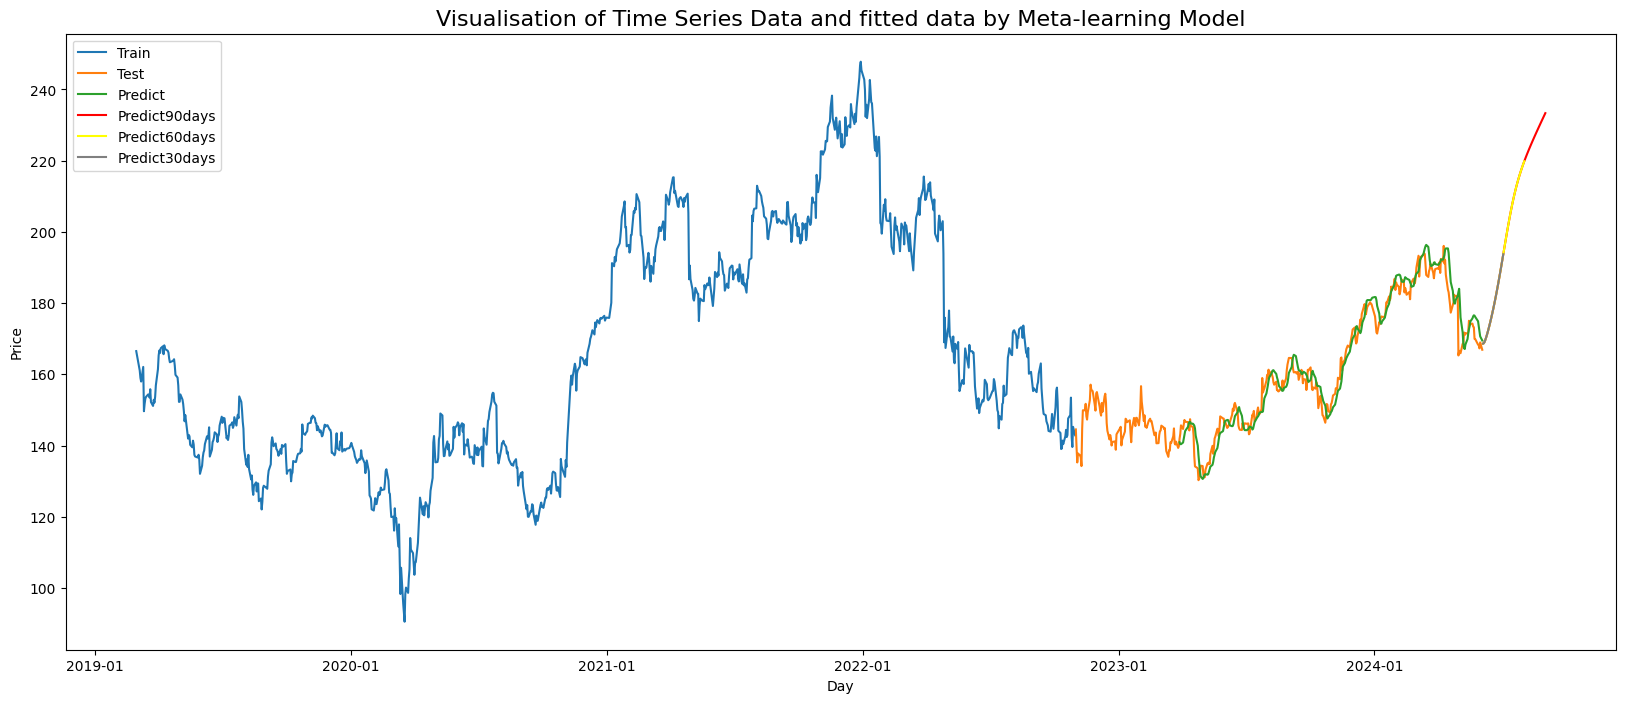

In [32]:
# 14.Vẽ hình
import matplotlib.dates as mdates
plt.figure(figsize=(20, 8))

data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'][:train_size],scaler.inverse_transform(train_data))
plt.plot(data['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(data['Date'][train_size+101:],(predictions))

predict_data_index_90 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of Time Series Data and fitted data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


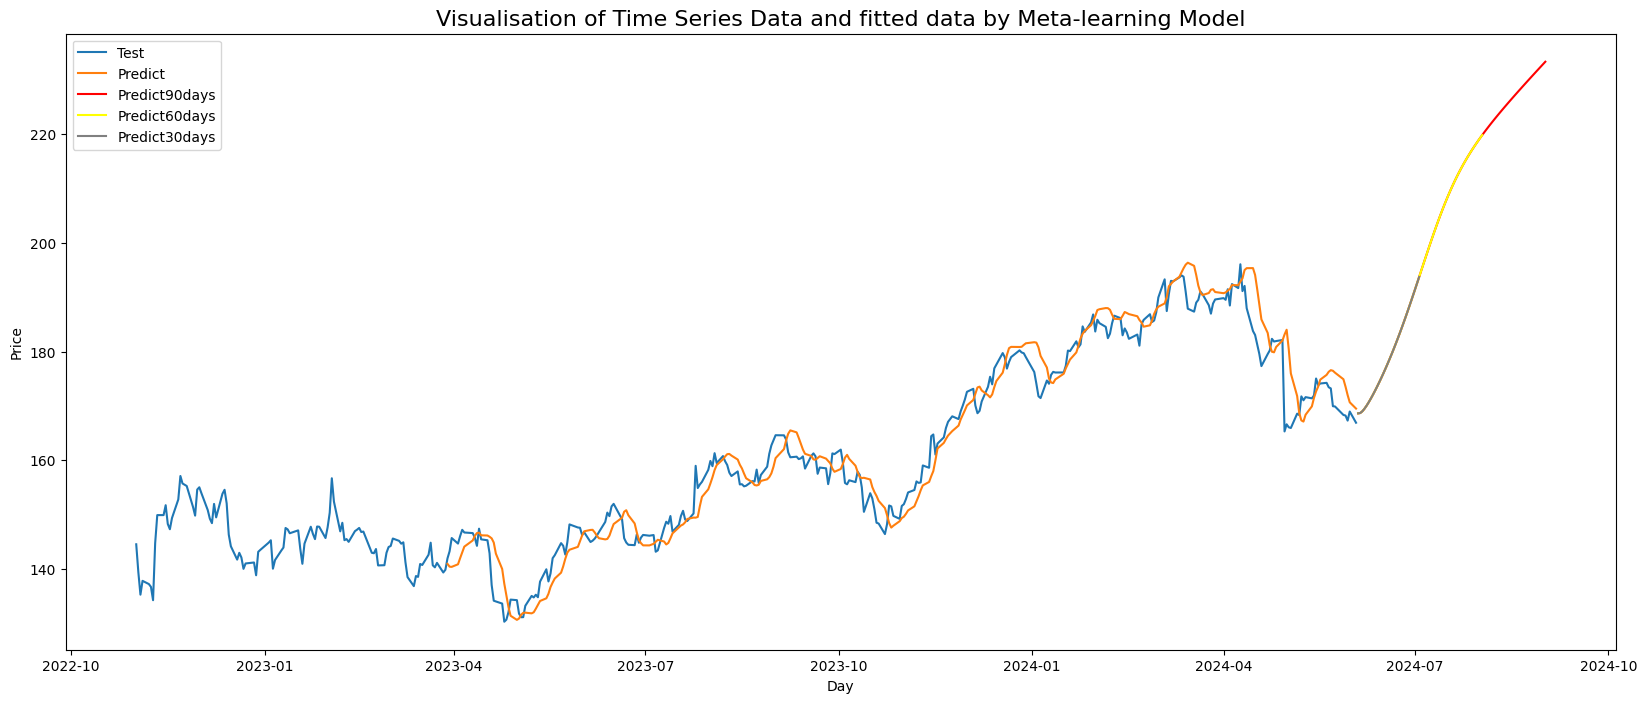

In [33]:
# 15.Vẽ hình test prediction
import matplotlib.dates as mdates
plt.figure(figsize=(20, 8))

data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(data['Date'][train_size+101:],(predictions))

predict_data_index_90 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of Time Series Data and fitted data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


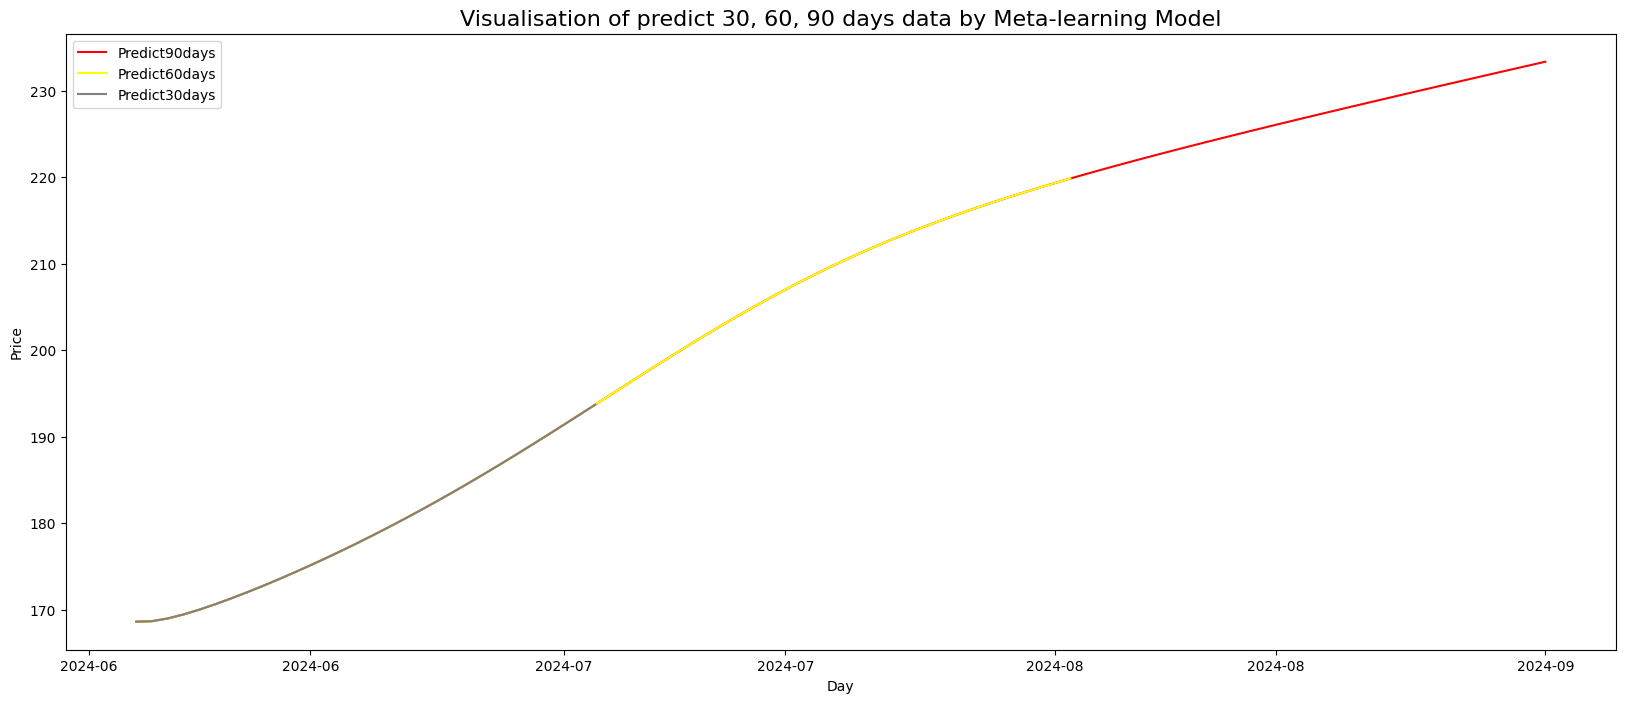

In [34]:
plt.figure(figsize=(20, 8))
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of predict 30, 60, 90 days data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()